**Instructions for Review/Evaluation:**

* Configure the run time to use GPU otherwise notebook might not complete execution due computational and memory limitations.
* Downloading of the Glove might take some time.
* Just in case you are not able to run the neural network for 10 epochs try reducing the epochs to 5.
* Just in case If you still encounter any issues with running notebook. Drop me an email saadwasem@gmail.com and I'll assist with running the code. Thanks.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#tensorflow
import tensorflow as tf

#keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam

#nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import re
import os

#wordclouds and cloud stopwords
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Path for the data
data_path = 'Sentiment140.tenPercent.sample.tweets.csv'

# Create a dataframe
tweets_data = pd.read_csv(data_path, sep='\t')
tweets_data.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [ ]:
tweets_data['sentiment_label'].unique()

array([4, 0])

Let's check for missig values.

In [ ]:
missing_data = tweets_data.isna().sum().sort_values(ascending=False)
percentage_missing = round((tweets_data.isnull().sum()/tweets_data.isnull().count()).sort_values(ascending=False)*100,2)
missing_info = pd.concat([missing_data,percentage_missing],keys=['Missing values','Percentage'],axis=1)
missing_info.style.background_gradient()

,Missing values,Percentage
sentiment_label,0,0.000000
tweet_text,0,0.000000


Lets double check numeric value for positive and negative sentiments. Does '0' means negative and '4' means positive sentiment?

In [ ]:
#show the whole value for column tweet_text
pd.set_option('display.max_colwidth', -1)
tweets_data[tweets_data['sentiment_label']==0]['tweet_text'].head(10)
#The data with '0' sentiment value is negative sentiment.

2     @greeniebach I reckon he'll play, even if he's not 100%...but i know nothing!! ;) It won't be the same without him.                    
3     @vaLewee I know!  Saw it on the news!                                                                                                  
4     very sad that http://www.fabchannel.com/ has closed down. One of the few web services that I've used for over 5 years                  
5     @Fearnecotton who sings 'I Remember'? i alwaysss hear it on Radio 1 but never catch the artist                                         
7     @LoveSmrs why being stupid?                                                                                                            
8     Having delved back into the guts of Expression Engine, its a flexible CMS if you have to use it as a dev, not great for clients though 
9     @emoskank awww   take him with you!                                                                                                    
11    

In [ ]:
#show the whole value for column tweet_text
pd.set_option('display.max_colwidth', -1)
tweets_data[tweets_data['sentiment_label']==4]['tweet_text'].head(10)
#The data with '4' sentiment value is positive sentiment.

0     @elephantbird Hey dear, Happy Friday to You  Already had your rice's bowl for lunch ?                              
1     Ughhh layin downnnn    Waiting for zeina to cook breakfast                                                         
6     With God on ur side anything is possible....                                                                       
10    the video on VH1 is much better than the u tube one                                                                
14    @ AshleyLTMSYF Hey Ashley  when will the Hush Hush; Hush Hush video be out? Can't wait )                           
15    Scratch that I enjoy seein people that left for college and came back for summer it makes me chuckle               
16    @demi_superfan1 hey im good sorry i took so long 2 reply  and im just chillin listening 2 music wbu?               
17    @Lydiajohn13 Good morning!!! You're up early... Chilling and chomping so far..  How is yours? And how was training?
18    @Joni2281 omggg no

In [ ]:
#changing numeric vlaues to more informative ones
tweets_data['sentiment_label'] = tweets_data['sentiment_label'].replace([0, 4],['Negative','Positive'])

Lets check sentiments distribution by constructing a pie chart.

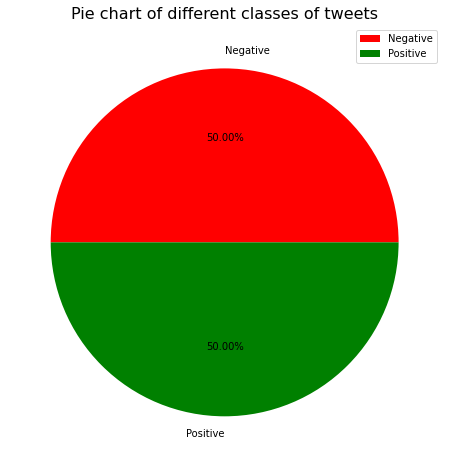

In [ ]:
# fig = plt.figure(figsize=(8,8))
targets = tweets_data.groupby('sentiment_label').size()
targets
targets.plot(kind='pie', subplots=True, figsize=(10, 8), autopct = "%.2f%%", colors=['red','green'])
plt.title("Pie chart of different classes of tweets",fontsize=16)
plt.ylabel("")
plt.legend()
plt.show()

It can be seen in the above pie chart data is equally distributed among postive and negative sentiments.

Lets Visualize repeated words for positive and negative tweets using wordcloud.

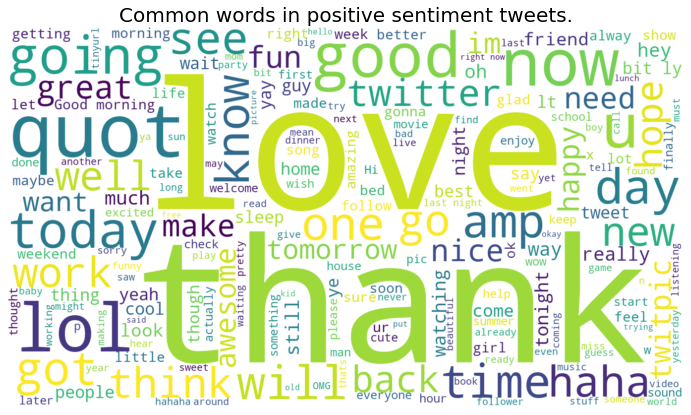

In [ ]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(tweets_data[tweets_data.sentiment_label=='Positive'].tweet_text))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Common words in positive sentiment tweets.',fontsize=20)
plt.show()

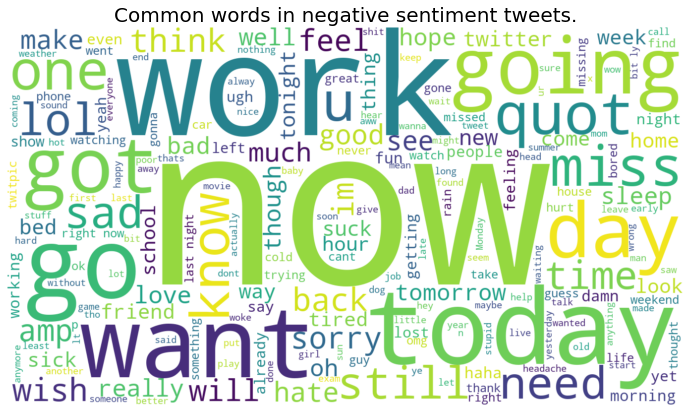

In [ ]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(tweets_data[tweets_data.sentiment_label=='Negative'].tweet_text))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Common words in negative sentiment tweets.',fontsize=20)
plt.show()

It can be seen that in postive tweets words like love, quot, lol, haha, thank, today are repeated. And for negative tweets words like miss, sorry, sad etc are mostly used. However there are few words that are used in both type of tweets like quot, lol, today they might not be very helpful in determining sentiment of tweet by a model.

Data pre-processing

In [ ]:
# replace target values with integers
tweets_data.sentiment_label = tweets_data.sentiment_label.replace({'Positive': 1, 'Negative': 0})

In [ ]:
#Stemming
#base of english stopwords
english_stopwords = stopwords.words('english')
#stemming algorithm
stemmer = SnowballStemmer('english')

#regex for mentions and links in tweets
regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess_tweet_text(tweet_text, stem=False):
  processed_text = re.sub(regex, ' ', str(tweet_text).lower()).strip()
  tokens = []
  for token in processed_text.split():
    if token not in english_stopwords:
      tokens.append(stemmer.stem(token))
  return " ".join(tokens)

In [ ]:
# Appy stemming and remove URLs
tweets_data.tweet_text = tweets_data.tweet_text.apply(preprocess_tweet_text)

In [ ]:
tweets_data.head()

,sentiment_label,tweet_text
0,1,hey dear happi friday alreadi rice bowl lunch
1,1,ughhh layin downnnn wait zeina cook breakfast
2,0,reckon play even 100 know noth without
3,0,know saw news
4,0,sad close one web servic use 5 year


In [ ]:
# split train and test datasets.
train, test = train_test_split(tweets_data, test_size=0.2, random_state=42)

In [ ]:
train.shape

(128000, 2)

Tokenization: I tokenized the tweet text using Tokenizer to get a vocabulary of words to be used with word embeddings.

In [ ]:
tokenizer = Tokenizer()
#fit once on train then it can be used multiple times with test and validation datasets
tokenizer.fit_on_texts(train.tweet_text)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
#sequence can be multiple times
sequences_train = tokenizer.texts_to_sequences(train.tweet_text)
sequences_test = tokenizer.texts_to_sequences(test.tweet_text)

In [ ]:
sequences_train[0]

[41, 3, 5, 777, 68, 453, 275]

In [ ]:
tweets_data['length'] = tweets_data.tweet_text.str.split().apply(len)

In [ ]:
tweets_data['sentiment_label']

0         1
1         1
2         0
3         0
4         0
         ..
159995    0
159996    0
159997    1
159998    1
159999    1
Name: sentiment_label, Length: 160000, dtype: int64

In [ ]:
describe = tweets_data.length[tweets_data.sentiment_label==1].describe().to_frame().round(2)
describe

,length
count,80000.00
mean,7.08
std,4.03
min,0.00
25%,4.00
50%,6.00
75%,10.00
max,30.00


In [ ]:
describe = tweets_data.length[tweets_data.sentiment_label==0].describe().to_frame().round(2)
describe

,length
count,80000.00
mean,7.35
std,4.07
min,0.00
25%,4.00
50%,7.00
75%,10.00
max,29.00


Make input text of equal length by applying padding

In [ ]:
max_length = 30 #based on the analysis
X_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
X_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')

y_train = train.sentiment_label.values
y_test = test.sentiment_label.values

In [ ]:
X_train[100]

array([ 4814, 20515,   993,  1054,   993,    17,    19, 20516,     7,
       20517,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int32)

Word embeddings with GloVe (Global Vectors)

This might take some time to download. As the file size is around 800mbs.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-02-22 16:11:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-22 16:11:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-22 16:11:20--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip -d /content

Archive:  glove.6B.zip
  inflating: /content/glove.6B.50d.txt  
  inflating: /content/glove.6B.100d.txt  
  inflating: /content/glove.6B.200d.txt  
  inflating: /content/glove.6B.300d.txt  


In [ ]:
import sys

In [ ]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('/content/glove.6B.100d.txt')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions


glove_file.close()

In [ ]:
embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

Modeling

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False)
num_epochs = 10 #due to computational limitations I am keeping it 5
batch_size = 1000

In [ ]:
model = Sequential([
        embedding_layer, #input layer
        #hidden layers
        tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)), #LSTM with 128 hidden units; return all hidden outputs
        tf.keras.layers.Dropout(0.3), #regularization to avoid overfitting
        tf.keras.layers.Bidirectional(LSTM(128)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'), #output layer for binary classification
    ])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           5508800   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 256)          234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                1

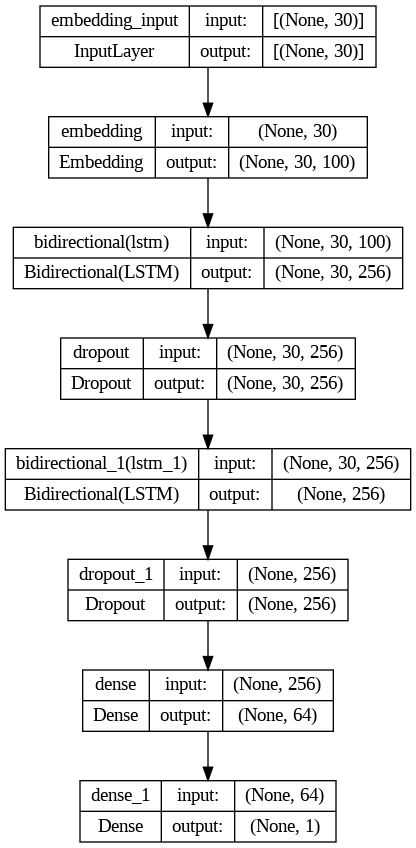

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
rnn_history = model.fit(X_train, y_train, batch_size = batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=2)

Epoch 1/10
128/128 - 18s - loss: 0.5959 - accuracy: 0.6741 - val_loss: 0.5627 - val_accuracy: 0.7035 - 18s/epoch - 137ms/step
Epoch 2/10
128/128 - 7s - loss: 0.5513 - accuracy: 0.7142 - val_loss: 0.5416 - val_accuracy: 0.7211 - 7s/epoch - 56ms/step
Epoch 3/10
128/128 - 7s - loss: 0.5358 - accuracy: 0.7277 - val_loss: 0.5367 - val_accuracy: 0.7263 - 7s/epoch - 56ms/step
Epoch 4/10
128/128 - 7s - loss: 0.5254 - accuracy: 0.7352 - val_loss: 0.5326 - val_accuracy: 0.7287 - 7s/epoch - 56ms/step
Epoch 5/10
128/128 - 7s - loss: 0.5165 - accuracy: 0.7411 - val_loss: 0.5268 - val_accuracy: 0.7318 - 7s/epoch - 56ms/step
Epoch 6/10
128/128 - 7s - loss: 0.5080 - accuracy: 0.7470 - val_loss: 0.5248 - val_accuracy: 0.7352 - 7s/epoch - 57ms/step
Epoch 7/10
128/128 - 7s - loss: 0.5012 - accuracy: 0.7508 - val_loss: 0.5303 - val_accuracy: 0.7293 - 7s/epoch - 58ms/step
Epoch 8/10
128/128 - 7s - loss: 0.4939 - accuracy: 0.7562 - val_loss: 0.5240 - val_accuracy: 0.7373 - 7s/epoch - 58ms/step
Epoch 9/10
12

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred>0.5, 1, 0)


1000/1000 [==============================] - 80s 77ms/step


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.69      0.72     16002
           1       0.72      0.78      0.74     15998

    accuracy                           0.73     32000
   macro avg       0.74      0.73      0.73     32000
weighted avg       0.74      0.73      0.73     32000



In [ ]:
from keras import regularizers
model = Sequential([
        embedding_layer, #input layer
        #hidden layers
        tf.keras.layers.Conv1D(100, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)),
        # tf.keras.layers.MaxPooling1D(pool_size=6, strides=1),
        # tf.keras.layers.Conv1D(100, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'), #output layer
    ])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
cnn_history = model.fit(X_train, y_train, batch_size = batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=2)

Epoch 1/10
128/128 - 29s - loss: 1.5812 - accuracy: 0.6508 - val_loss: 0.6569 - val_accuracy: 0.6916 - 29s/epoch - 229ms/step
Epoch 2/10
128/128 - 29s - loss: 0.6441 - accuracy: 0.7005 - val_loss: 0.6359 - val_accuracy: 0.7047 - 29s/epoch - 223ms/step
Epoch 3/10
128/128 - 27s - loss: 0.6346 - accuracy: 0.7074 - val_loss: 0.6361 - val_accuracy: 0.7047 - 27s/epoch - 211ms/step
Epoch 4/10
128/128 - 27s - loss: 0.6275 - accuracy: 0.7108 - val_loss: 0.6261 - val_accuracy: 0.7102 - 27s/epoch - 210ms/step
Epoch 5/10
128/128 - 27s - loss: 0.6236 - accuracy: 0.7114 - val_loss: 0.6224 - val_accuracy: 0.7097 - 27s/epoch - 211ms/step
Epoch 6/10
128/128 - 27s - loss: 0.6214 - accuracy: 0.7137 - val_loss: 0.6185 - val_accuracy: 0.7113 - 27s/epoch - 212ms/step
Epoch 7/10
128/128 - 27s - loss: 0.6184 - accuracy: 0.7154 - val_loss: 0.6188 - val_accuracy: 0.7123 - 27s/epoch - 209ms/step
Epoch 8/10
128/128 - 27s - loss: 0.6190 - accuracy: 0.7145 - val_loss: 0.6184 - val_accuracy: 0.7109 - 27s/epoch - 207

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           5508800   
                                                                 
 conv1d (Conv1D)             (None, 25, 100)           60100     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 64)                6464      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,575,429
Trainable params: 66,629
Non-trainable params: 5,508,800
_______________________________________

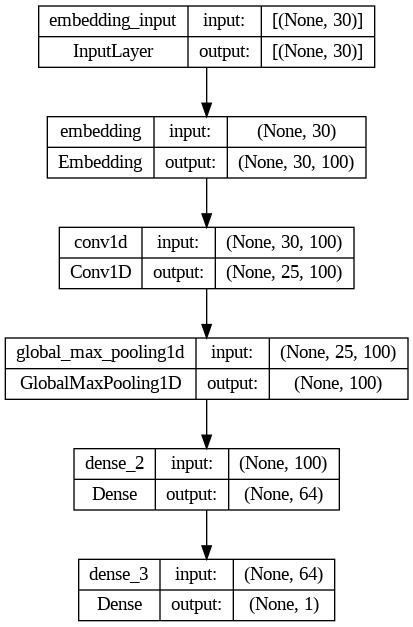

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred>0.5, 1, 0)
print(classification_report(y_test, y_pred))

1000/1000 [==============================] - 3s 3ms/step
              precision    recall  f1-score   support

           0       0.74      0.67      0.70     16002
           1       0.70      0.76      0.73     15998

    accuracy                           0.72     32000
   macro avg       0.72      0.72      0.72     32000
weighted avg       0.72      0.72      0.72     32000



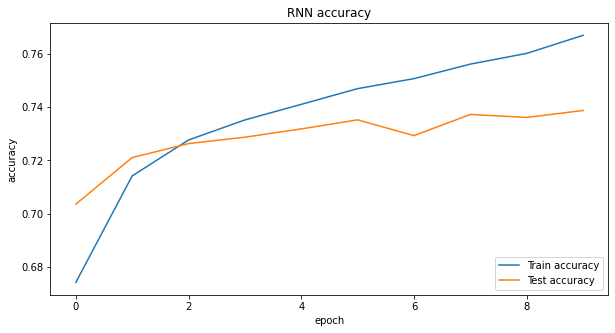

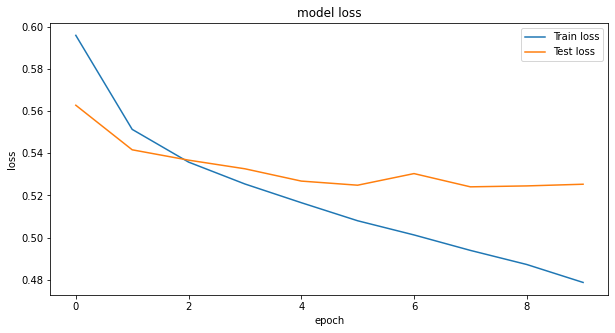

In [ ]:
#History for accuracy
plt.figure(figsize=(10,5))
plt.plot(rnn_history.history['accuracy'])
plt.plot(rnn_history.history['val_accuracy'])
plt.title('RNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
plt.show()
# History for loss
plt.figure(figsize=(10,5))
plt.plot(rnn_history.history['loss'])
plt.plot(rnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.show()

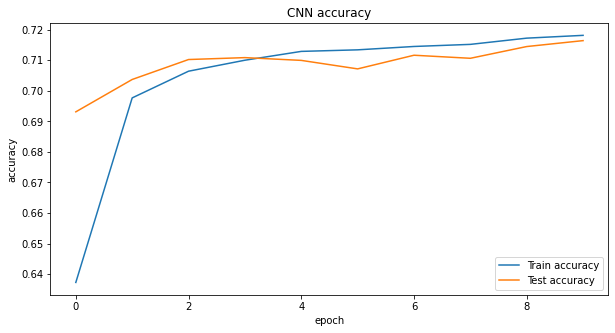

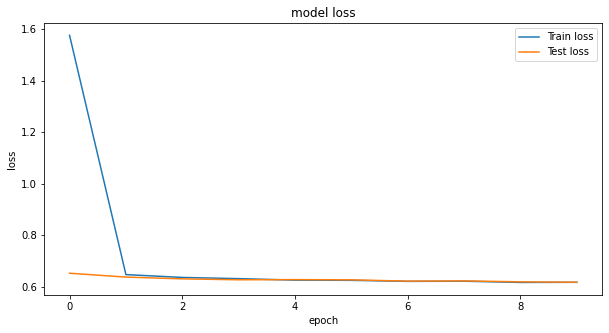

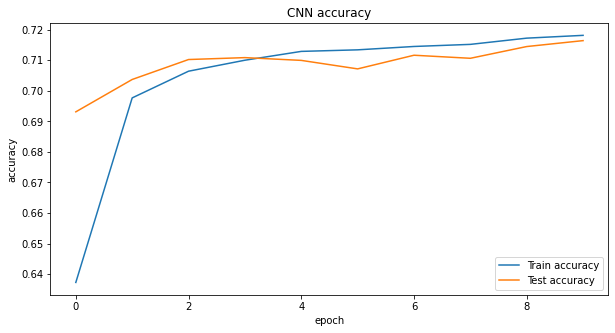

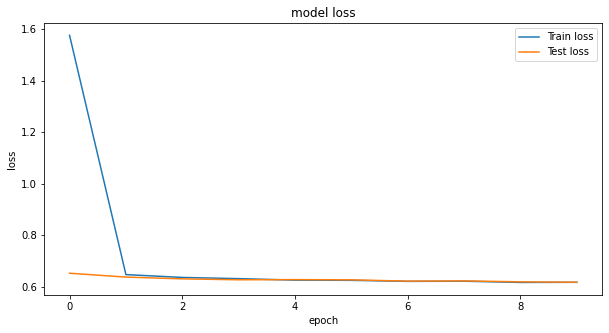

In [ ]:
#History for accuracy
plt.figure(figsize=(10,5))
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
plt.show()
# History for loss
plt.figure(figsize=(10,5))
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
# plt.suptitle('Accuracy and loss for CNN')
plt.show()